In [20]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions


%matplotlib inline

In [21]:
data = pd.read_csv("nasdaq100_padding.csv")
data.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


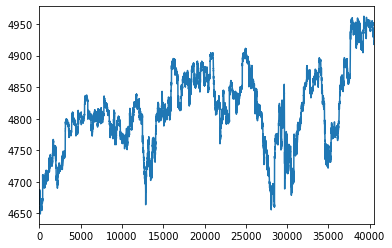

In [22]:
data["NDX"].plot()
plt.show()

In [23]:
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730

In [24]:
prediction_horizon = 1
y_true = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [25]:
y_true

array([4665.054, 4665.826, 4667.081, ..., 4922.949, 4922.942, 4922.942])

In [26]:
y = data['NDX'].values
y

array([4665.054, 4665.054, 4665.826, ..., 4921.884, 4922.949, 4922.942])

# Error Metric

In [27]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Current

In [28]:
true = y_true[-val_length:]
pred = y[-val_length:]

In [29]:
mean_squared_error(pred,true)

1.9995778142857559

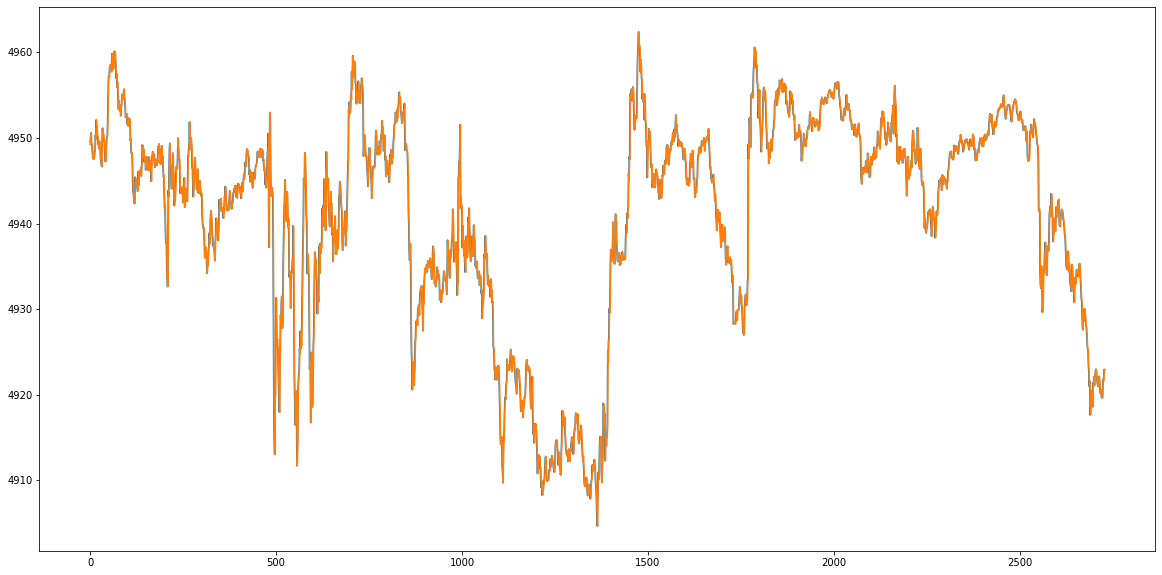

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(true)
plt.plot(pred)
plt.show()

# 2. Moving Average

In [31]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return pd.Series(series).rolling(n).mean()

In [32]:
y_ma_pred = moving_average(y, 1000) # prediction for the last observed day (past 1 hour)
mean_squared_error(y_ma_pred[-val_length:], true)

513.9202699567417

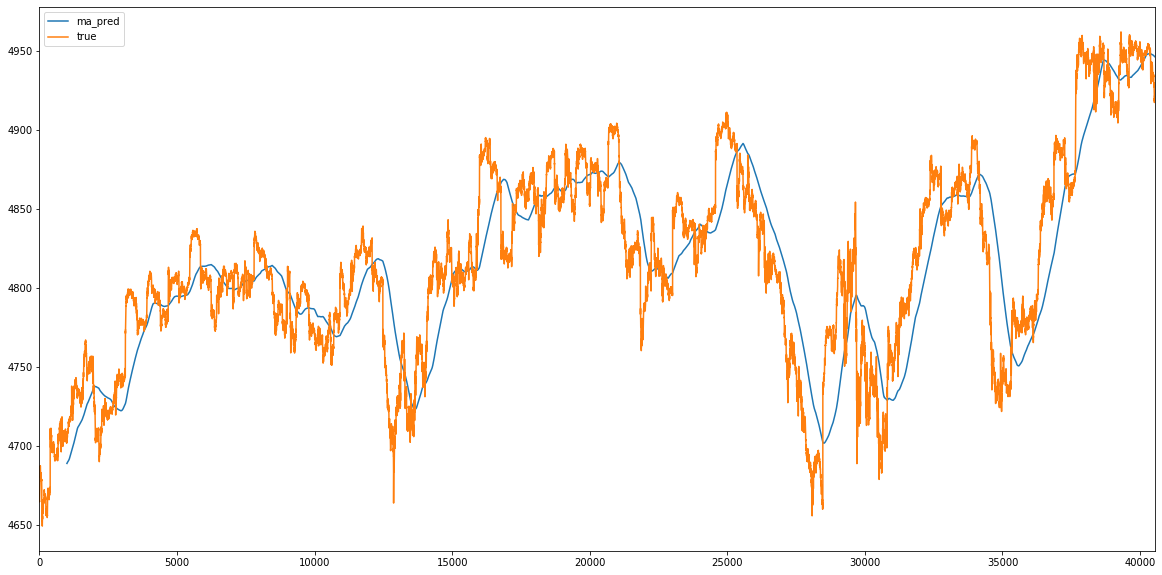

In [33]:
pd.DataFrame(np.c_[y_ma_pred, y], columns=['ma_pred', 'true']).plot(figsize=(20,10))

# Weighted Average

In [34]:
def weighted_average(series, weights):
    """
        Calculate weighted average of last n observations
    """
    return pd.Series(series).rolling(len(weights)).apply(lambda x: np.average(x, weights=weights))

In [35]:
y_wa_pred = weighted_average(y, [0, 0, 1]) # prediction for the last observed day (past 1 hour)
mean_squared_error(y_wa_pred[-val_length:], true)

1.9995778142857559

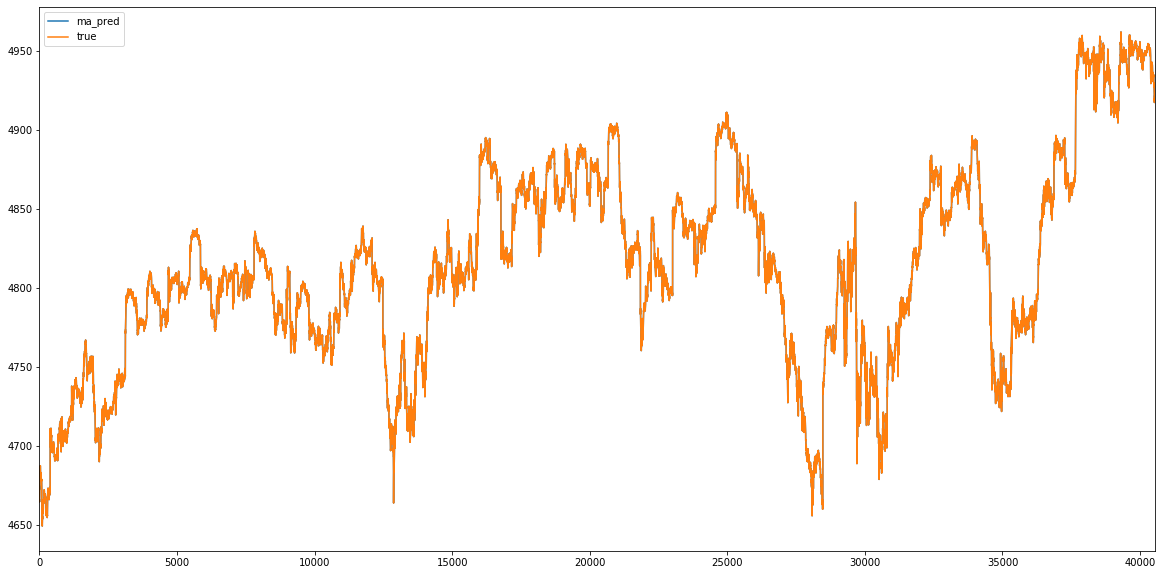

In [36]:
pd.DataFrame(np.c_[y_wa_pred, y], columns=['ma_pred', 'true']).plot(figsize=(20,10))

# Exponential Smoothing

In [37]:
y_ewa_pred = weighted_average(y, .001 ** np.arange(1000, 0, -1)) # prediction for the last observed day (past 1 hour)
mean_squared_error(y_ewa_pred[-val_length:], true)

2.0000852186448737

# Double Exponential Smoothing

In [38]:
from sklearn.linear_model import LinearRegression
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def window_split(raw_data, train_n, test_n):
    raw_data.dropna(inplace=True)
    length = raw_data.shape[0]
    train_starts = np.arange(0, length - train_n - test_n + 1, test_n)
    test_starts = np.arange(train_n, length + 1, test_n)[:len(train_starts)]
    trains = [raw_data.iloc[s:s+train_n] for s in train_starts]
    tests = [raw_data.iloc[s:s+test_n] for s in test_starts]
    return trains, tests

def prediction(trains, tests):
    ols = LinearRegression()
    price_preds = np.array([])
    price_trues = np.array([])
    for i in range(len(trains)):
        ols.fit(trains[i].drop(columns=['pch', 'NDX']), trains[i]['pch'])
        y_pred = ols.predict(tests[i].drop(columns=['pch', 'NDX']))
        price_preds = np.append(price_preds, trains[i].NDX.iloc[-1] + y_pred)
        price_trues = np.append(price_trues, tests[i]['NDX'].values)
    return price_preds, price_trues

In [44]:
def AR_fit(data, p):
    global train_length
    global val_length
    global test_length
    X = data[['NDX']].copy()
    X['pch'] = X.diff()
    for i in range(p):
        X['lag'+str(i+1)] = X.pch.shift(i+1)
    X.dropna(inplace=True)
    trains, tests = window_split(X.iloc[-(train_length - (p+1) + val_length+test_length):], train_length-(p+1)+val_length, 1)
    ols_pred, ols_true = prediction(trains, tests)
    return ols_pred, ols_true

#### AR(p)

In [40]:
ols_pred, ols_true, trains, tests = AR_fit(data, 1)
np.sqrt(mean_squared_error(ols_pred, ols_true))

1.4097972594078403

In [41]:
len(trains), type(trains)

(2730, list)

In [42]:
#trains[1]

In [43]:
ols_pred, ols_true = AR_fit(data, 2)
np.sqrt(mean_squared_error(ols_pred, ols_true))

ValueError: too many values to unpack (expected 2)

In [ ]:
ols_pred, ols_true = AR_fit(data, 3)
np.sqrt(mean_squared_error(ols_pred, ols_true))

In [ ]:
ols_pred, ols_true = AR_fit(data, 4)
np.sqrt(mean_squared_error(ols_pred, ols_true))

In [ ]:
ols_pred, ols_true = AR_fit(data, 5)
np.sqrt(mean_squared_error(ols_pred, ols_true))

#### XG boost

In [45]:
X = data[['NDX']].copy()
X['pch'] = X.diff()
p=3
for i in range(p):
    X['lag'+str(i+1)] = X.pch.shift(i+1)
trains, tests = window_split(X.iloc[-(train_length - (p+1) + val_length+test_length):], train_length-(p+1)+val_length, 1)

In [46]:
len(trains)

2730

In [47]:
def prediction_xgboost(trains, tests):
    xgb = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=4,
       min_child_weight=100, missing=None, n_estimators=100, nthread=-1,
       objective='reg:squarederror', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, subsample=0.75)
    price_preds = np.array([])
    price_trues = np.array([])
    for i in range(len(trains)):
        print('{:.2f}%'.format(i / (len(trains)+1) * 100), end='\r')
        xgb.fit(trains[i].drop(columns=['pch', 'NDX']), trains[i]['pch'])
        y_pred = xgb.predict(tests[i].drop(columns=['pch', 'NDX']))
        price_preds = np.append(price_preds, trains[i].NDX.iloc[-1] + y_pred)
        price_trues = np.append(price_trues, tests[i]['NDX'].values)
    return price_preds, price_trues

In [50]:
from xgboost import XGBRegressor 

In [51]:
xgb = XGBRegressor(objective ='reg:squarederror')

In [52]:
xgb.fit(trains[1].drop(columns=['pch', 'NDX']), trains[1]['pch'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [53]:
xgb.predict(tests[1].drop(columns=['pch', 'NDX']))

array([-0.38095528], dtype=float32)

In [54]:
def xgb_fit(data, p):
    global train_length
    global val_length
    global test_length
    X = data[['NDX']].copy()
    X['pch'] = X.diff()
    for i in range(p):
        X['lag'+str(i+1)] = X.pch.shift(i+1)
    X.dropna(inplace=True)
    trains, tests = window_split(X.iloc[-(train_length - (p+1) + val_length+test_length):], train_length-(p+1)+val_length, 1)
    xgb_pred, xgb_true = prediction_xgboost(trains, tests)
    return xgb_pred, xgb_true

In [ ]:
xgb_pred, xgb_true = xgb_fit(data, 4)
np.sqrt(mean_squared_error(xgb_pred, xgb_true))

In [55]:
xgb_pred, xgb_true = xgb_fit(data, 4)
np.sqrt(mean_squared_error(xgb_pred, xgb_true))

1.4094770109341541

In [56]:
xgb_pred, xgb_true = xgb_fit(data, 12)
np.sqrt(mean_squared_error(xgb_pred, xgb_true))

1.4112399393611375